# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

## Required Environment Variables

This notebook requires the following environment variables in your `.env` file:

```bash
# Azure OpenAI Configuration
AOAI_ENDPOINT=your_azure_openai_endpoint
AOAI_KEY=your_azure_openai_api_key
AOAI_API_VERSION=2024-02-01  # Optional, defaults to this value

# Model Deployment Names
reasoningModel=your_reasoning_model_deployment_name  # e.g., o1-preview
chatModel=your_chat_model_deployment_name  # e.g., gpt-4o

# Azure AI Projects Configuration
PROJECT_ENDPOINT=your_azure_ai_project_endpoint

# Bing Search Agent (pre-created in Azure AI Foundry)
bingSearchAgentID=your_bing_search_agent_id
BING_CONNECTION_NAME=your_bing_connection_name  # Only needed if creating agent inline
```

**Note:** This notebook creates agents inline using the OpenAI Agents SDK, except for the Bing Search agent which must be pre-created in Azure AI Foundry. If you haven't created the Bing Search agent yet, uncomment and run the agent creation cell below.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
import os
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

### Creating the Bing Search Agent (One-time Setup)

The following cell will **create** an **Azure AI Agent** with Bing Search capabilities. You only need to run this cell **once** to create the agent, then save its ID to your `.env` file as `bingSearchAgentID`.

If you already have a Bing Search agent created, skip this cell and use the next cell to update its instructions instead.

In [5]:
# from azure.ai.agents.models import BingGroundingTool

# import datetime
# current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# bing_connection = project_client.connections.get(
#     name=os.getenv("BING_CONNECTION_NAME")
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="bingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model=os.getenv("chatModel"),
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions=f"""
# You are a helpful research assistant.

# Today's date is {current_date}.

# Use your available tools (like Bing web search) to find information relevant to the user's query.
# When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
# Provide a comprehensive answer based on the search results.
#     """.strip()
# )

### Updating Existing Bing Search Agent

If you already have a Bing Search agent (with its ID in your `.env` file), run this cell to update its instructions with today's date. This ensures the agent has current date awareness for time-sensitive queries.

In [6]:
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-11-03.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


### Creating OpenAI Agents

The following agents are created inline using the OpenAI Agents SDK. These agents handle planning, summarization, research synthesis, and peer review. They are created fresh each time you run the notebook.

In [7]:
from agents import (
    Agent,
    ModelSettings
)

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 5 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)

peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)


**hand-offs**

In [8]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

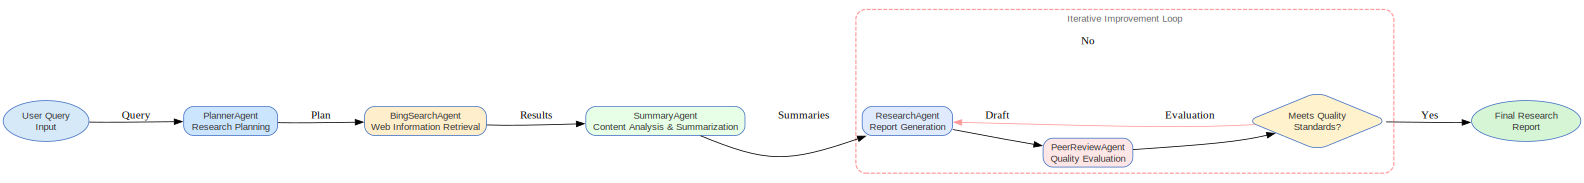

In [9]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [10]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [11]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [12]:
plan.final_output.research_tasks[0].search_queries

['What is classical machine learning?',
 'Definition of deep learning in AI',
 'What is generative AI and how does it work?',
 'Overview of machine learning paradigms']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [13]:
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            message = project_client.agents.messages.create(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.runs.create_and_process(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 5/5 [08:33<00:00, 102.67s/it]


In [14]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 20

Actually total search queries: 20



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [15]:
from common.utils_summary import collect_responses_and_citations

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    all_agent_responses_for_subtopic, unique_citations_for_subtopic = collect_responses_and_citations(subtopic_result)

    # --- Summarize the combined agent responses ONCE per subtopic ---
    content_to_summarize = "\n\n---\n\n".join(all_agent_responses_for_subtopic)

    subtopic_summary = "No content found to summarize for this subtopic." # Default value
    if content_to_summarize:
        summary_prompt = f"Summarize the following information related to the subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content_to_summarize}"
        try:
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=summary_prompt
            )
            subtopic_summary = summary_response.final_output # Adjust based on actual response structure
        except Exception as e:
            print(f"Error summarizing subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}': {e}")
            subtopic_summary = f"Error during summarization for subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}'. Details: {e}"
            # Depending on requirements, you might want to raise the exception, log it, or handle it differently

    # --- Convert set of tuples back to list of dictionaries (or Citation objects) ---
    citations_list = [
        {"title": title, "url": url}
        for title, url in unique_citations_for_subtopic
    ]

    # --- Append the consolidated result ---
    mapped_chunks.append({
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"), # Use .get for safety
        "summary": subtopic_summary,
        "citations": citations_list
    })

Summarizing subtopics: 100%|██████████| 5/5 [02:38<00:00, 31.62s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [16]:
plan.final_output

ResearchPlan(query='What are the differences between classical machine learning, deep learning and generative AI?', objective='To comprehensively analyze and compare classical machine learning, deep learning, and generative AI, highlighting their fundamental differences in methodology, architecture, applications, strengths, and limitations.', success_criteria=['Clear definitions and explanations of classical machine learning, deep learning, and generative AI are provided.', 'Key differences between the three approaches are identified and explained across multiple dimensions (e.g., methodology, architecture, data requirements, performance, applications).', 'Examples and use cases for each approach are included to illustrate practical distinctions.', 'Comparative tables or summaries are presented to facilitate quick understanding of the differences.', 'Sources and references from reputable academic or industry publications are included.'], related_topics=['Supervised vs. unsupervised lea

In [17]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan.final_output, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [18]:
from agents import HandoffCallItem
import json

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [19]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Comparative Analysis of Classical Machine Learning, Deep Learning, and Generative AI

## Introduction

Artificial intelligence (AI) has undergone a profound transformation over the past several decades, evolving from rule-based expert systems to sophisticated models capable of learning, reasoning, and even creating new content. Central to this evolution are three paradigms: classical machine learning (ML), deep learning (DL), and generative AI. Each represents a distinct approach to solving computational problems, with unique methodologies, architectures, data requirements, and application domains. As AI technologies become increasingly integrated into industry, healthcare, finance, and everyday life, understanding the differences and complementarities among these paradigms is essential for both practitioners and decision-makers. This report provides an in-depth comparative analysis of classical machine learning, deep learning, and generative AI, exploring their foundational concepts, methodological and architectural distinctions, data dependencies, performance characteristics, practical applications, and inherent strengths and limitations. By synthesizing insights from academic literature and industry sources, the report aims to clarify the trade-offs and synergies that define the current landscape of AI, offering a comprehensive resource for those seeking to leverage these technologies effectively.

## 1. Definitions and Foundational Concepts

The conceptual foundations of classical machine learning, deep learning, and generative AI are rooted in the broader field of artificial intelligence, yet each paradigm is distinguished by its approach to learning, representation, and problem-solving. Classical machine learning refers to a suite of statistical algorithms designed to discover patterns and relationships in structured data. These algorithms are typically categorized into three primary paradigms: supervised learning, unsupervised learning, and reinforcement learning. Supervised learning involves training models on labeled datasets to predict outcomes for new data, using algorithms such as linear regression, logistic regression, decision trees, and support vector machines. Unsupervised learning, by contrast, seeks to uncover hidden structures in unlabeled data, employing techniques like k-means clustering and principal component analysis (PCA) to group similar data points or reduce dimensionality. Reinforcement learning introduces an agent that interacts with an environment, learning optimal policies through feedback in the form of rewards or penalties, with methods such as Q-learning and REINFORCE being prominent examples [1][2][3][4][5].

Classical machine learning is characterized by its reliance on explicit statistical modeling and manual feature engineering. Domain experts play a critical role in selecting and crafting input variables, which are then used by algorithms to make predictions or classifications. This approach is well-suited to structured data—such as tabular datasets found in finance, healthcare, and retail—and is generally less demanding in terms of computational resources and data volume. Key concepts such as overfitting (where a model captures noise rather than signal), the bias-variance trade-off (balancing model complexity to avoid underfitting or overfitting), and model evaluation (using cross-validation and bootstrapping) are central to effective model development and assessment [6][7][8].

Deep learning represents a significant evolution within machine learning, defined by its use of multilayered neural networks inspired by the human brain. These networks consist of interconnected neurons organized in multiple layers, enabling the automatic extraction and learning of complex features from raw, often unstructured data. The term "deep" refers to the presence of three or more layers, allowing the model to learn increasingly abstract representations—for example, progressing from detecting edges to recognizing faces in image data. Deep learning models can be trained using supervised, semi-supervised, or unsupervised methods and excel at tasks requiring sophisticated pattern recognition, including computer vision, natural language processing, and speech recognition. Their distributed, flexible architecture allows them to approximate complex functions and solve problems that are intractable for traditional algorithms [9][10][11][12][13].

Generative AI builds on deep learning by focusing on the creation of new content—text, images, audio, video, or code—based on learned data patterns. Unlike traditional AI, which primarily analyzes or automates tasks, generative AI models synthesize original outputs in response to user prompts, closely mimicking human creativity. The process involves training on massive datasets to learn statistical structures, generating new content by sampling from these learned distributions, and iterative tuning to refine outputs. Foundational concepts include the distinction between generative models (which create new examples by modeling the data distribution) and discriminative models (which classify or distinguish between categories). Neural networks are central to generative AI, enabling the synthesis of realistic and novel outputs. Popular platforms like ChatGPT and DALL-E exemplify generative AI’s transformative impact on industries by automating creative tasks and augmenting human expression [14][15][16][17][18].

Across all these domains, foundational concepts such as features and feature vectors, model training and evaluation, and the choice of learning paradigm guide algorithm selection and application. The interplay between classical machine learning, deep learning, and generative AI reflects the ongoing evolution of AI capabilities—from statistical pattern recognition in structured data to autonomous feature learning and creative synthesis in unstructured domains. This progression underscores the importance of understanding definitions and foundational concepts to effectively leverage AI technologies for diverse real-world challenges, while also highlighting the trade-offs and complementarities between different approaches.

## 2. Methodological and Architectural Differences

The methodological and architectural distinctions among classical machine learning, deep learning, and generative AI are central to their respective strengths, limitations, and appropriate use cases. Classical machine learning is characterized by manual feature engineering, where domain experts select and craft the most relevant input variables from structured datasets. This process, while labor-intensive, results in models that are typically shallow—such as decision trees, support vector machines, and linear/logistic regression—and highly interpretable. Classical ML models excel in scenarios with smaller, structured datasets, such as tabular data for fraud detection or customer segmentation, and can be efficiently trained and deployed on standard CPUs due to their relatively low computational requirements [19][20][21][22].

In contrast, deep learning automates the feature extraction process through multi-layered neural networks, enabling the learning of hierarchical feature representations directly from raw data. This methodological shift allows DL models to handle high-dimensional, unstructured data such as images, audio, and natural language. Architecturally, deep learning models are composed of dozens or even hundreds of interconnected layers, each extracting progressively more abstract features. Examples include Convolutional Neural Networks (CNNs) for spatial data (images), Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks for sequential data (text, speech), and transformers for natural language processing. The depth and complexity of these architectures necessitate vast amounts of training data and powerful hardware (GPUs or TPUs), making DL resource-intensive but highly effective for complex tasks like image classification, speech recognition, and autonomous driving [23][24][25][26][27].

Generative AI represents a further specialization within deep learning, focusing on the creation of new data that mimics the patterns found in the training set. Methodologically, generative AI models learn the underlying distribution of input data and sample from this distribution to generate novel outputs. Architectures such as Generative Adversarial Networks (GANs), which pit a generator against a discriminator in an adversarial setup, and Variational Autoencoders (VAEs), which encode and decode data through a latent space, are designed specifically for data synthesis. Large Language Models (LLMs) like GPT use transformer-based architectures with attention mechanisms to generate coherent and contextually relevant text. These generative models require even larger datasets and greater computational resources than traditional DL models, but they enable creative applications such as text generation (ChatGPT), image synthesis (DALL-E), and music or video creation [28][29][30][31].

The distinction between methodology and architecture is crucial: methodology refers to the approach or technique used to solve a problem (e.g., supervised vs. unsupervised learning, sequence modeling vs. classification), while architecture describes the structural design of the model (e.g., layers, nodes, activation functions). For example, a CNN architecture is methodologically suited for supervised learning tasks in image classification, whereas a GAN architecture is tailored for adversarial training and data generation [32][33].

Interpretability is another key differentiator. Classical ML models are generally transparent, allowing users to trace predictions back to specific features and understand the decision-making process. Deep learning and generative AI models, due to their depth and complexity, are often considered "black boxes," making interpretation and troubleshooting more challenging [34][35].

From a systems perspective, machine learning architecture also encompasses the broader workflow, including data ingestion, preprocessing, model training, evaluation, and deployment. A well-designed architecture ensures scalability, maintainability, and efficiency in building ML solutions. The choice between classical ML, deep learning, and generative AI depends on the nature of the data, the complexity of the task, the need for interpretability, and available computational resources [36][37].

### Comparative Table: Methodology and Architecture

| Paradigm         | Methodology           | Architecture         | Feature Engineering | Data Type           | Interpretability |
|------------------|----------------------|----------------------|--------------------|---------------------|------------------|
| Classical ML     | Manual, statistical  | Shallow (1-2 layers) | Manual             | Structured/tabular  | High             |
| Deep Learning    | Automated, hierarchical | Deep (multi-layer)  | Automatic          | Unstructured (images, text, audio) | Low              |
| Generative AI    | Data synthesis, adversarial | Deep, specialized (GANs, VAEs, Transformers) | Automatic          | Unstructured, diverse | Very Low         |

## 3. Data Requirements and Performance Characteristics

The comparison of data requirements and performance characteristics across classical machine learning, deep learning, and generative AI reveals fundamental differences in their operational paradigms, scalability, and suitability for various tasks. Classical machine learning algorithms, such as linear regression, decision trees, support vector machines, and random forests, are optimized for structured, tabular data and perform well with relatively modest datasets—typically ranging from thousands to tens of thousands of examples. These models rely heavily on manual feature engineering, where domain experts select and preprocess relevant attributes to maximize predictive accuracy. The interpretability and computational efficiency of classical ML make it ideal for applications in regulated industries (e.g., finance, healthcare, retail) and real-time scenarios, as models can be trained and deployed on standard CPUs with short training times [38][39][40][41][42].

However, classical ML models face limitations as data complexity and volume increase. Their performance tends to plateau with larger datasets, particularly when dealing with high-dimensional or unstructured data types such as images, audio, or text. Manual feature selection becomes a bottleneck, and the models may struggle to capture intricate, non-linear relationships inherent in complex data. Despite these constraints, classical ML remains highly interpretable, offering transparency in decision-making and facilitating troubleshooting—a critical advantage in domains where explainability is paramount [43][44].

In contrast, deep learning models, built on multi-layered neural networks, are designed to automatically extract features from raw, unstructured data. Architectures such as Convolutional Neural Networks (CNNs) for images, Recurrent Neural Networks (RNNs) for sequences, and Transformers for text have revolutionized fields like computer vision, speech recognition, and natural language processing. Deep learning excels when provided with large-scale, diverse datasets—often requiring tens or hundreds of thousands of labeled examples to reach optimal performance. Unlike classical ML, deep learning models continue to improve as more data is supplied, exhibiting a “data-hungry” nature. This scalability comes at the cost of increased computational demands, necessitating powerful hardware (GPUs/TPUs) and longer training times. Deep learning models are less interpretable due to their complexity but can capture highly non-linear and abstract patterns, achieving state-of-the-art results in tasks where classical ML falters [45][46][47][48][49].

Generative AI models, including Generative Adversarial Networks (GANs) and Large Language Models (LLMs) like GPT-3 and GPT-4, push data requirements to new extremes. For instance, GPT-3 utilizes 175 billion parameters and is trained on hundreds of gigabytes to petabytes of text data, while GPT-4 leverages 1.8 trillion parameters and even larger datasets. Image-based generative models, such as Style-GANs, require millions of high-resolution images, translating to several terabytes of storage. Speech synthesis models similarly demand extensive, diverse audio datasets to produce realistic outputs across different voices, accents, and languages. The complexity of generative tasks—synthesizing new, realistic data samples—means that both the quantity and diversity of training data are critical for avoiding bias and ensuring generalization. Infrastructure for storing, processing, and managing these vast datasets becomes a central concern for organizations deploying generative AI at scale [50][51][52][53].

Several factors influence the data requirements for these models: the type of learning (supervised models require more labeled data), task complexity (more challenging tasks demand exponentially more data), and the need for variability and diversity to prevent bias. Techniques such as data augmentation, transfer learning, and AutoML are increasingly employed to address data scarcity, synthetically expand datasets, and leverage pre-trained models. AutoML-based augmentation methods have demonstrated superior performance over traditional approaches, further boosting generalization and accuracy, especially in deep learning and generative AI contexts [54][55][56].

Performance characteristics across these paradigms reflect their data dependencies. Classical ML offers rapid training and inference, high interpretability, and efficiency with small, structured datasets but struggles with scalability and unstructured data. Deep learning models require substantial computational resources and training time, but their performance scales with data volume, excelling in complex, high-dimensional tasks. Generative AI models set new benchmarks in creative and synthetic domains but are constrained by massive data and resource requirements, with performance closely tied to the quality and diversity of training data [57][58][59].

### Data and Performance Comparison Table

| Paradigm         | Typical Data Volume   | Data Type           | Computational Needs | Training Time | Scalability | Performance with Data |
|------------------|----------------------|---------------------|--------------------|--------------|-------------|----------------------|
| Classical ML     | Thousands to tens of thousands | Structured/tabular  | Low (CPU)          | Short        | Limited     | Plateaus             |
| Deep Learning    | Tens to hundreds of thousands | Unstructured (images, text, audio) | High (GPU/TPU) | Long        | High        | Improves with more data |
| Generative AI    | Hundreds of GB to PB, billions/trillions of parameters | Unstructured, diverse | Very High (GPU/TPU clusters) | Very Long   | Extreme     | Strongly dependent on data |

## 4. Applications and Use Cases

The landscape of applications and use cases for classical machine learning, deep learning, and generative AI is both vast and rapidly evolving, with each paradigm offering distinct strengths and industry adoption patterns. Classical machine learning is characterized by its reliance on traditional algorithms such as decision trees, support vector machines, k-nearest neighbors, linear and logistic regression, and clustering methods like k-means. These models thrive in environments with structured data and are favored for their interpretability, lower computational requirements, and robustness in well-defined tasks [60][61][62][63][64].

In finance, classical ML underpins fraud detection systems—using logistic regression and decision trees to flag anomalous transactions in real-time—and credit risk assessment, where supervised learning predicts loan defaults and evaluates creditworthiness. In healthcare, SVM and logistic regression classify patient data for disease diagnosis and predictive analytics, forecasting outcomes and identifying high-risk patients. Marketing and retail leverage k-nearest neighbors and decision trees for recommendation systems, while k-means clustering enables customer segmentation for targeted campaigns. Cybersecurity applications include anomaly detection in network traffic and spam filtering via classification algorithms. In supply chain and operations, regression models forecast product demand, and clustering/classification algorithms aid in quality control by detecting manufacturing defects. Education benefits from student performance prediction models, and insurance uses classical ML for risk assessment and premium setting. In NLP, algorithms like Naive Bayes and SVM support sentiment analysis and text classification, while in image and speech recognition, classical methods remain relevant for simpler tasks such as handwriting recognition [65][66][67][68].

Deep learning builds on the foundation of classical ML, extending capabilities to process vast amounts of unstructured data—images, audio, and text—through neural networks, especially convolutional neural networks (CNNs) and recurrent neural networks (RNNs). In healthcare, deep learning revolutionizes medical image analysis, detecting tumors and anomalies in X-rays, MRIs, and CT scans with high accuracy. Predictive analytics and drug discovery are also enhanced by deep learning’s ability to model complex patient data and molecular interactions. In finance, deep learning models analyze transaction patterns for real-time fraud detection, drive algorithmic trading by interpreting market trends, and improve credit scoring by integrating diverse data sources. Retail applications include personalized recommendations, inventory management optimization, and visual recognition for automated checkout systems. The automotive sector relies on deep learning for self-driving cars, enabling real-time sensor data analysis for navigation, object detection, and driver assistance features like lane-keeping and collision avoidance. Entertainment and media utilize deep learning for content recommendation, image/video enhancement, and restoration tasks. In manufacturing, predictive maintenance and automated quality control are achieved through sensor data analysis and defect detection. NLP applications encompass virtual assistants (Alexa, Siri, Google Assistant), chatbots, and machine translation, while deep learning also powers demographic predictions, election forecasting, and superhuman game-playing capabilities [69][70][71][72][73].

Generative AI represents a further specialization within deep learning, focusing on the creation of new data that mimics the training set. Generative models—such as Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), and large language models (LLMs) like GPT-4 and Claude—require extensive datasets and significant computational resources. Text generation is a prominent use case, with tools automating article drafting, meeting summarization, email writing, and marketing copy creation, often integrated into CRM and customer support platforms. Image and design creation is facilitated by platforms like Midjourney and DALL·E, which generate visuals for advertising, product concepts, and brand assets; automotive companies, such as Toyota, leverage generative AI for rapid vehicle design iteration. Audio and voice synthesis tools like ElevenLabs and Descript enable lifelike voice cloning and audio cleanup, supporting sales and training workflows. Code generation is streamlined by GitHub Copilot, which drafts code and automates QA, enhancing developer productivity. Customer service automation is exemplified by Ally Bank’s AI-powered contact center assistant and LinkedIn’s next-gen job search and support, utilizing LLMs and retrieval-augmented generation (RAG) for semantic search and knowledge management. Personalization and recommendations are advanced by foundation models at Netflix, Yelp, and LinkedIn, improving content delivery and job matching. Knowledge management and document automation are optimized by Intuit’s generative AI solutions, reducing manual effort in business operations. In healthcare, generative AI personalizes patient care, automates documentation, and generates synthetic medical data for research. Backend automation across industries streamlines high-volume workflows and reduces costs through intelligent agents and targeted predictions [74][75][76][77][78].

### Comparative Table: Applications and Use Cases

| Paradigm         | Main Use Cases                              | Example Applications                   |
|------------------|---------------------------------------------|----------------------------------------|
| Classical ML     | Prediction, classification, recommendation  | Fraud detection, sales forecasting     |
| Deep Learning    | Complex pattern recognition in unstructured data | Image recognition, NLP, autonomous cars |
| Generative AI    | Content creation, simulation, synthetic data | Text/image/video generation, chatbots  |

In summary, classical machine learning, deep learning, and generative AI each play pivotal roles in modern industry, with their applications tailored to the nature of the data, the complexity of the task, and the desired outcome—whether it be prediction, pattern recognition, or creative generation. Their continued evolution and integration are driving efficiency, personalization, and innovation across finance, healthcare, retail, automotive, manufacturing, entertainment, technology, and beyond. Open questions remain regarding the ethical deployment, interpretability, and resource management of these technologies as their use cases expand.

## 5. Strengths, Limitations, and Challenges

A nuanced comparison of the strengths, limitations, and challenges associated with classical machine learning, deep learning, and generative AI reveals the trade-offs that shape their practical deployment and ongoing research. Classical machine learning is characterized by its reliance on traditional algorithms such as decision trees, support vector machines, linear regression, and k-nearest neighbors. Its primary strengths lie in the automation of repetitive tasks, improved decision-making through actionable insights, and robust pattern recognition capabilities. Classical ML models are highly interpretable and generally simpler than their deep learning counterparts, making them preferable in regulatory environments or situations where transparency is critical. They are computationally efficient, cost-effective, and can be trained quickly, especially on smaller, structured datasets. Manual feature engineering allows domain experts to inject specialized knowledge, often leading to better performance on targeted tasks [79][80][81][82].

However, classical ML is limited by its dependence on large volumes of high-quality, labeled data, which can be expensive and difficult to obtain. These models may struggle with unstructured data (such as images or text) and are less adept at capturing complex, non-linear relationships compared to deep learning models. Overfitting and underfitting are persistent risks, and while simple models are interpretable, more complex ensemble methods can become opaque. Implementation requires specialized expertise and infrastructure, and manual feature selection can hinder adaptability to new domains. Challenges also include ensuring data quality, selecting and tuning appropriate models, mitigating bias and fairness issues, and integrating ML systems into existing workflows for sustained performance [83][84][85].

Deep learning, leveraging architectures like convolutional neural networks (CNNs), recurrent neural networks (RNNs), and transformers, has revolutionized fields such as computer vision, natural language processing, and speech recognition. Its strengths are rooted in automatic feature extraction from raw data, exceptional performance with unstructured data types, and scalability to vast datasets and complex patterns. DL models have set benchmarks for state-of-the-art accuracy in numerous domains, often outperforming classical ML on tasks involving high-dimensional or unstructured data [86][87][88].

Despite these advances, deep learning is highly data-hungry, requiring extensive labeled datasets for effective training. Computational resource requirements are substantial, often necessitating specialized hardware (GPUs/TPUs), which increases energy consumption and infrastructure costs. The "black box" nature of deep neural networks poses significant challenges for explainability, particularly in sensitive domains like healthcare and finance. DL models are vulnerable to bias if the training data is skewed, and adversarial attacks can exploit model weaknesses, leading to incorrect predictions. Generalization to new contexts remains an open problem, with overfitting and underfitting still concerns. Deployment in resource-constrained environments is difficult, and scaling models further is often limited by hardware and infrastructure [89][90][91][92].

Generative AI systems, such as large language models (LLMs) and generative adversarial networks (GANs), have opened new frontiers in creativity, automation, and personalization. They excel at producing novel outputs—text, images, music, and more—by learning patterns from massive datasets. This capability supports innovation in content creation, entertainment, and scientific discovery, while enabling personalized solutions in medicine, education, and user interfaces. Generative AI automates complex creative tasks, driving efficiency and adaptability across industries [93][94][95][96].

However, generative AI is fundamentally constrained by its dependence on vast, high-quality, and diverse data. Poor or biased data can result in inaccurate, unrealistic, or harmful outputs. Generalization to new or unseen data is limited, and models can be unreliable or erroneous with small input changes. Ethical concerns are paramount, as generative AI can facilitate disinformation (e.g., deepfakes), perpetuate bias, and raise intellectual property (IP) questions due to learning from copyrighted material. Cybersecurity risks are heightened, with adversarial vulnerabilities and the potential for automated cyber threats. The opacity of generative models complicates transparency and regulatory compliance, and resource intensity for training and deployment is significant, with environmental impacts to consider [97][98][99][100].

Comparative analysis reveals that while classical ML is favored for its interpretability and efficiency with structured data, it is less suited for complex or unstructured tasks. Deep learning surpasses classical ML in handling complexity and unstructured data but at the cost of explainability and resource demands. Generative AI extends the capabilities of DL by enabling creative content generation and personalization, but amplifies challenges related to ethics, trust, and resource consumption.

Across all paradigms, persistent challenges include ensuring data quality and availability, selecting and tuning models, mitigating bias and fairness issues, and maintaining robust, secure, and transparent systems. The trade-offs between interpretability, scalability, resource requirements, and ethical considerations shape the choice of approach for specific applications. Ongoing research is focused on developing more efficient, interpretable, and robust models, as well as complementary methods to address the limitations and challenges inherent in each paradigm.

### Impact Assessment Matrix: Strengths and Limitations Across Industries

| Paradigm         | Strengths              | Limitations           | Key Challenges         | Example Industry Impact |
|------------------|-----------------------|-----------------------|-----------------------|------------------------|
| Classical ML     | Interpretability, efficiency, cost-effectiveness | Struggles with complex/unstructured data, manual feature engineering | Data quality, bias, scalability | Finance (fraud detection), healthcare (risk assessment) |
| Deep Learning    | Automatic feature extraction, state-of-the-art accuracy, scalability | Data/resource intensity, low interpretability, bias/adversarial vulnerability | Explainability, resource management, generalization | Healthcare (medical imaging), automotive (autonomous vehicles) |
| Generative AI    | Content creation, personalization, automation | Data dependence, ethical risks, explainability, resource demands | Bias, fairness, IP, cybersecurity, transparency | Entertainment (content generation), technology (code synthesis), healthcare (synthetic data) |

## 6. Synthesis and Future Directions

The evolution from classical machine learning to deep learning and generative AI reflects a trajectory toward greater capability and complexity, but also introduces new layers of technical, ethical, and operational challenges. Classical ML remains indispensable for structured, interpretable, and resource-efficient applications, while deep learning has unlocked breakthroughs in unstructured data analysis and complex pattern recognition. Generative AI, by enabling creative synthesis and automation, is reshaping industries and workflows, but also amplifies concerns around data quality, bias, explainability, and resource consumption.

As AI technologies continue to advance, hybrid approaches are emerging, leveraging the strengths of each paradigm. For example, transfer learning and AutoML techniques are bridging gaps between data-scarce environments and high-performance models, while explainable AI (XAI) research aims to improve transparency and trust in deep learning and generative systems. Ethical frameworks and regulatory guidelines are being developed to address issues of fairness, accountability, and intellectual property, ensuring responsible deployment of AI in society.

The future of AI will likely be defined by the integration of classical ML, deep learning, and generative AI, with ongoing research focused on overcoming current limitations and expanding the applicability of these technologies. Key areas of innovation include efficient model architectures, robust data augmentation strategies, improved interpretability, and scalable infrastructure for training and deployment. As organizations and researchers navigate this complex landscape, a nuanced understanding of the differences, complementarities, and challenges among these paradigms will be essential for harnessing the full potential of artificial intelligence.

## References

[1] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/classic-and-adaptive-machines/
[2] Deep learning - Wikipedia, https://en.wikipedia.org/wiki/Deep_learning
[3] Machine Learning Fundamentals Handbook – Key Concepts, Algorithms, and ..., https://www.freecodecamp.org/news/machine-learning-handbook/
[4] What is Generative AI (GenAI)? Definition, How It Works, Applications ..., https://www.sciencenewstoday.org/what-is-generative-ai-genai-definition-how-it-works-applications-and-future-impact
[5] Machine Learning Paradigms - Introduction to Machine Learning - Wolfram, https://www.wolfram.com/language/introduction-machine-learning/machine-learning-paradigms/
[6] Core Concepts of Machine Learning (classical) | GRAUSOFT, https://grausoft.net/core-concepts-of-machine-learning/
[7] What Is Generative AI (GenAI)? How Does It Work? - Oracle, https://www.oracle.com/artificial-intelligence/generative-ai/what-is-generative-ai/
[8] Fundamentals of Machine Learning | part of Machine Learning and ..., https://ieeexplore.ieee.org/document/10753126
[9] Overview of Machine Learning Part 1: Fundamentals and Classic ..., https://www.sciencedirect.com/science/article/pii/S1052514920300629
[10] What Is Deep Learning? Definition, Examples, and Careers, https://www.coursera.org/articles/what-is-deep-learning
[11] What Is Generative AI? How It Works, Examples, Benefits, and ..., https://www.coursera.org/articles/what-is-generative-ai
[12] How does generative AI work? - Microsoft AI, https://www.microsoft.com/en-us/ai/ai-101/how-does-generative-ai-work
[13] Machine Learning - an overview | ScienceDirect Topics, https://www.sciencedirect.com/topics/computer-science/machine-learning
[14] What is generative AI? - IBM, https://www.ibm.com/think/topics/generative-ai
[15] What is Deep Learning? - Deep Learning AI Explained - AWS, https://aws.amazon.com/what-is/deep-learning/
[16] What is deep learning? - IBM, https://www.ibm.com/think/topics/deep-learning
[17] A Comprehensive Review of Deep Learning: Architectures, Recent Advances ..., https://www.mdpi.com/2078-2489/15/12/755
[18] Top Machine Learning Architectures Explained - BMC Software, https://www.bmc.com/blogs/machine-learning-architecture/
[19] Deep Learning vs. Traditional Machine Learning: Which is Better?, https://www.alliancetek.com/blog/post/2025/03/11/deep-learning-vs-traditional-ml.aspx
[20] Machine Learning Architecture: What It Is, Components & Types, https://lakefs.io/blog/machine-learning-architecture/
[21] machine learning - What is the difference between ML architecture and ..., https://stats.stackexchange.com/questions/323524/what-is-the-difference-between-ml-architecture-and-ml-model
[22] Deep Learning vs Generative AI: Understanding the Key Differences - eWeek, https://www.eweek.com/artificial-intelligence/generative-ai-vs-deep-learning/
[23] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks | IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks
[24] AI vs ML vs DL vs GenAI: Key Differences Explained - FS.com, https://www.fs.com/blog/artificial-intelligence-vs-machine-learning-vs-deep-learning-vs-generative-ai-key-differences-explained-24134.html
[25] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[26] Difference Between Machine Learning and Deep Learning, https://www.geeksforgeeks.org/artificial-intelligence/difference-between-machine-learning-and-deep-learning/
[27] Deep learning vs. machine learning: Understanding the ... - Elastic, https://www.elastic.co/blog/deep-learning-vs-machine-learning
[28] Data augmentation with automated machine learning: approaches and ..., https://link.springer.com/article/10.1007/s10115-025-02349-x
[29] How Much Training Data Is Enough to Run a Successful ML Model? - Shaip, https://www.shaip.com/blog/how-much-training-data-is-enough/
[30] Deep learning vs. classic machine learning: differences you should know ..., https://iartificial.blog/en/learning/Deep-learning-vs.-classic-machine-learning%3A-differences-you-should-know/
[31] Benchmarking Classical, Deep, and Generative Models for Human Activity ..., https://arxiv.org/pdf/2501.08471v1
[32] CPU vs. GPU: Performance Evaluation of Classical Machine and Deep ..., https://ieeexplore.ieee.org/document/10959248
[33] How Much Data Do You Need to Train an AI - Inside Machine Learning, https://inside-machinelearning.com/en/how-much-data/
[34] How to build a data strategy for generative AI | IBM, https://www.ibm.com/think/insights/data-strategy-for-generative-ai
[35] Comparing Deep Learning and Traditional Machine Learning, https://theceoviews.com/comparing-deep-learning-and-traditional-machine-learning/
[36] Here’s How Much Data Gets Used By Generative AI Tools For Each Request, https://www.datasciencecentral.com/heres-how-much-data-gets-used-by-generative-ai-tools-for-each-request/
[37] Systematic Analysis of Deep Learning Models vs. Machine Learning, https://www.researchgate.net/profile/Sheshang-Degadwala/publication/382093842_Systematic_Analysis_of_Deep_Learning_Models_vs_Machine_Learning/links/668d4258c1cf0d77ffc88f11/Systematic-Analysis-of-Deep-Learning-Models-vs-Machine-Learning.pdf
[38] Deep Learning Scalability: A Survey of Challenges, Techniques, and ..., https://ieeexplore.ieee.org/document/11077544
[39] Comparative Analysis of Traditional Machine Learning and Deep Learning ..., https://www.ewadirect.com/proceedings/ace/article/view/20929
[40] 10 Examples of Deep Learning Applications - Coursera, https://www.coursera.org/articles/deep-learning-applications
[41] Top 20 Deep Learning Applications Across Industries 2024, https://www.pickl.ai/blog/deep-learning-applications/
[42] Generative AI Use Cases Across Industries | Gartner, https://www.gartner.com/en/articles/generative-ai-use-cases
[43] Classical Machine Learning vs. Generative AI: Key Differences, https://clarkstonconsulting.com/insights/machine-learning-vs-generative-ai/
[44] Machine Learning Examples, Applications & Use Cases | IBM, https://www.ibm.com/think/topics/machine-learning-use-cases
[45] Applications of machine learning: top 12 use cases in 2025, https://helpware.com/blog/tech/applications-of-machine-learning
[46] Top 20 Applications of Deep Learning in 2025 Across Industries, https://www.mygreatlearning.com/blog/deep-learning-applications/
[47] Machine Learning Theory and Applications: Hands-on Use Cases with ..., https://books.google.com/books/about/Machine_Learning_Theory_and_Applications.html?id=BrvtEAAAQBAJ
[48] Gen AI use cases in 2025: learnings from 650+ examples, https://www.evidentlyai.com/blog/gen-ai-use-cases
[49] Generative AI vs. Machine Learning: What’s the Difference?, https://www.coursera.org/articles/generative-ai-vs-machine-learning
[50] Top 30 Deep Learning Best Applications in 2025 - Dirox, https://dirox.com/post/deep-learning-best-applications
[51] 10 Top Machine Learning Algorithms & Their Use-Cases, https://www.datacamp.com/blog/top-machine-learning-use-cases-and-algorithms
[52] Top 25 Deep Learning Applications Used Across Industries, https://www.simplilearn.com/tutorials/deep-learning-tutorial/deep-learning-applications
[53] Generative AI vs Machine Learning - GeeksforGeeks, https://www.geeksforgeeks.org/artificial-intelligence/generative-ai-vs-machine-learning/
[54] 28 Generative AI Examples (2025): Use Cases Across Industries, https://www.lindy.ai/blog/generative-ai-examples
[55] 15 Machine Learning Use Cases and Applications in 2025 - ProjectPro, https://www.projectpro.io/article/machine-learning-use-cases/476
[56] Challenges Facing Generative AI Development - Simple Science, https://scisimple.com/en/articles/2025-09-03-challenges-facing-generative-ai-development--a9m1ze0
[57] Limitations of Deep Learning : What Are the Challenges?, https://mohammedsameer.info/limitations-of-deep-learning-what-are-the-challenges/
[58] Advantages and Disadvantages of Machine Learning, https://www.geeksforgeeks.org/machine-learning/what-is-machine-learning/
[59] Advantages and Disadvantages of Machine Learning [ML] 2025, https://collegevidya.com/blog/advantages-and-disadvantages-of-machine-learning/
[60] Generative AI: Advantages, Disadvantages, Limitations, and Challenges, https://fact.technology/learn/generative-ai-advantages-limitations-and-challenges/
[61] Comparing Deep Learning and Traditional Machine Learning, https://theceoviews.com/comparing-deep-learning-and-traditional-machine-learning/
[62] 10 Major Challenges of Generative AI & How to Overcome Them, https://www.theiotacademy.co/blog/challenges-of-generative-ai/
[63] Deep Learning vs. Traditional Machine Learning: Which is Better?, https://www.alliancetek.com/blog/post/2025/03/11/deep-learning-vs-traditional-ml.aspx
[64] Classical ML vs Deep Learning 2023 | by Anirban Bose | Medium, https://medium.com/@bosea949/classical-ml-vs-deep-learning-2023-3ade040dfddb
[65] The Computational Limits of Deep Learning, https://cbmm.mit.edu/sites/default/files/documents/2020-07-10%20Thompson-Greenewald-Lee-Manso%20-%20Deep_Learning_Limitations%20-%20Neil%20Thompson.pdf
[66] A Critical Analysis of Generative AI: Challenges, Opportunities, and ..., https://link.springer.com/article/10.1007/s11831-025-10355-z
[67] Challenges in Deep Learning - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/challenges-in-deep-learning/
[68] A Comprehensive Analysis of Classical Machine Learning and Modern Deep ..., https://www.ijert.org/a-comprehensive-analysis-of-classical-machine-learning-and-modern-deep-learning-methodologies
[69] The limitations of deep learning - Keras, https://blog.keras.io/the-limitations-of-deep-learning.html
[70] Understanding The Limitations Of Generative AI, https://www.forbes.com/councils/forbestechcouncil/2024/05/09/understanding-the-limitations-of-generative-ai/
[71] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[72] 5 Reasons Why Traditional Machine Learning is Alive and Well in the Age ..., https://machinelearningmastery.com/5-reasons-why-traditional-machine-learning-is-alive-and-well-in-the-age-of-llms/
[73] Deep learning: systematic review, models, challenges, and research ..., https://link.springer.com/article/10.1007/s00521-023-08957-4


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [20]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To comprehensively analyze and compare classical machine learning, deep learning, and generative AI, highlighting their fundamental differences in methodology, architecture, applications, strengths, and limitations.",
  "aggregated_summaries": [
    {
      "subtopic": "Definitions and foundational concepts",
      "summary": "## Key Insights\n- Classical machine learning is defined by foundational statistical algorithms for supervised, unsupervised, and reinforcement learning, focusing on pattern discovery in structured data.\n- Deep learning is a subset of machine learning that uses multilayered neural networks to automatically extract complex features from raw, often unstructured data, enabling advanced tasks like computer vision and